## Homework 03

### Assignment 2: MNIST Classification

#### 2.1 Loading Dataset

In [1]:
import tensorflow_datasets as tfds
import tensorflow as tf
from tensorflow.keras.layers import Dense
import numpy as np
import matplotlib.pyplot as plt

C:\Users\berit\AppData\Local\Continuum\miniconda3\envs\iannwtf\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
(train_ds, test_ds), ds_info = tfds.load('mnist', split =['train', 'test'],
                                               as_supervised =True , with_info = True )

In [3]:
print(ds_info)

tfds.core.DatasetInfo(
    name='mnist',
    full_name='mnist/3.0.1',
    description="""
    The MNIST database of handwritten digits.
    """,
    homepage='http://yann.lecun.com/exdb/mnist/',
    data_path='C:\\Users\\berit\\tensorflow_datasets\\mnist\\3.0.1',
    file_format=tfrecord,
    download_size=11.06 MiB,
    dataset_size=21.00 MiB,
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=10000, num_shards=1>,
        'train': <SplitInfo num_examples=60000, num_shards=1>,
    },
    citation="""@article{lecun2010mnist,
      title={MNIST handwritten digit database},
      author={LeCun, Yann and Cortes, Corinna and Burges, CJ},
      journal={ATT Labs [Online]. Available: http://yann.lecun.com/exdb/mnist},
      volume={2},
      year={2010}
    }

* How many training/test images are there? 10000 test images and 6000 training images    
* What’s the image shape? image shape is (28,28,1)
* What range are pixel values in? image values from range 0 to 255


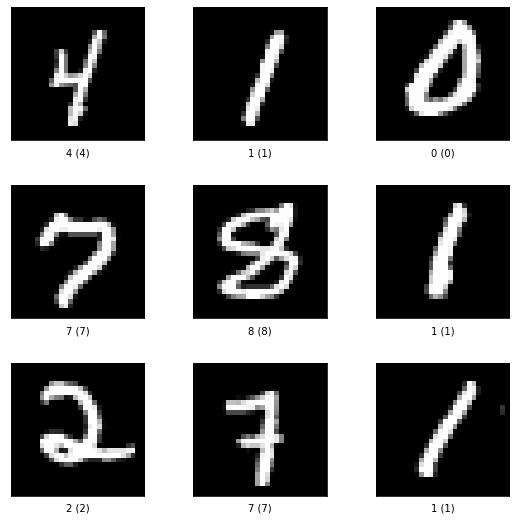

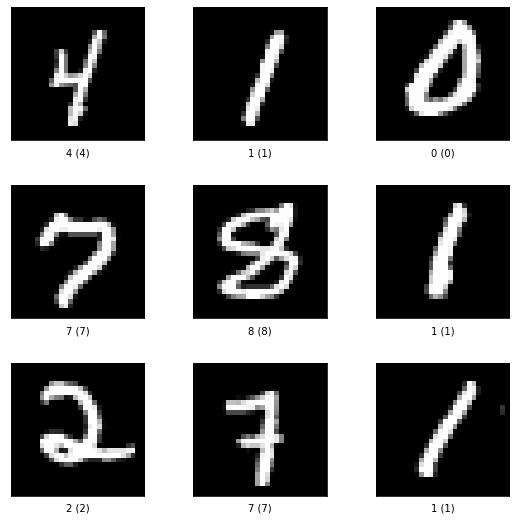

In [4]:
tfds.show_examples(train_ds, ds_info)

#### 2.2 Data pipeline

In [5]:
def prepare_mnist_data(mnist):
    #flatten the images into vectors
    mnist = mnist.map(lambda img, target: (tf.reshape(img, (-1,)), target))
    #convert data from uint8 to float32
    mnist = mnist.map(lambda img, target: (tf.cast(img, tf.float32), target))
    #sloppy input normalization, just bringing image values from range [0, 255] to [-1, 1]
    mnist = mnist.map(lambda img, target: ((img/128.)-1., target))
    #create one-hot targets
    mnist = mnist.map(lambda img, target: (img, tf.one_hot(target, depth=10)))
    #cache this progress in memory, as there is no need to redo it; it is deterministic after all
    mnist = mnist.cache()
    #shuffle, batch, prefetch
    mnist = mnist.shuffle(1000)
    mnist = mnist.batch(32)
    mnist = mnist.prefetch(20)
    #return preprocessed dataset
    return mnist

train_dataset = train_ds.apply(prepare_mnist_data)
test_dataset = test_ds.apply(prepare_mnist_data)

#### 2.3 Deep Neural Network 

In [6]:
class FFNN(tf.keras.Model):
    
    def __init__(self):
        super(FFNN, self).__init__()
        # 2 hidden layers with 256 units each 
        self.dense1 = tf.keras.layers.Dense(256, activation=tf.nn.relu)
        self.dense2 = tf.keras.layers.Dense(256, activation=tf.nn.relu)
        # 10 units for output layer since there are 10 digits to classify
        self.out = tf.keras.layers.Dense(10, activation=tf.nn.softmax)

    @tf.function
    def call(self, inputs):
        x = self.dense1(inputs)
        x = self.dense2(x)
        x = self.out(x)
        return x

#### 2.4 Training

In [7]:
def train_step(model, input, target, loss_function, optimizer):
  # loss_object and optimizer_object are instances of respective tensorflow classes
    with tf.GradientTape() as tape:
        prediction = model(input)
        loss = loss_function(target, prediction)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss


def test(model, test_data, loss_function):
  # test over complete test data
    test_accuracy_aggregator = []
    test_loss_aggregator = []
    
    for (input, target) in test_data:
        prediction = model(input)
        sample_test_loss = loss_function(target, prediction)
        sample_test_accuracy =  np.argmax(target, axis=1) == np.argmax(prediction, axis=1)
        sample_test_accuracy = np.mean(sample_test_accuracy)
        test_loss_aggregator.append(sample_test_loss.numpy())
        test_accuracy_aggregator.append(np.mean(sample_test_accuracy))
    
    test_loss = tf.reduce_mean(test_loss_aggregator)
    test_accuracy = tf.reduce_mean(test_accuracy_aggregator)

    return test_loss, test_accuracy

In [8]:
# hyperparameters
num_epochs = 10
learning_rate = 0.1

# model initialization 
model = FFNN()
# loss initialization (categorical cross entropy loss) 
cross_entropy_loss = tf.keras.losses.CategoricalCrossentropy()
# optimizer initialization (Stochastic Gradient Descent) 
optimizer = tf.keras.optimizers.SGD(learning_rate)

# initialization lists for training
train_losses = []
test_losses = []
test_accuracies = []

# testing on untrained model  
test_loss, test_accuracy = test(model, test_dataset, cross_entropy_loss)
test_losses.append(test_loss)
test_accuracies.append(test_accuracy)

# loss of untrained model
train_loss, _ = test(model, train_dataset, cross_entropy_loss)
train_losses.append(train_loss)

# We train for num_epochs epochs.
for epoch in range(num_epochs):
    print(f'Epoch: {str(epoch)} starting with accuracy {test_accuracies[-1]}')

    #training (and checking in with training)
    epoch_loss_agg = []
    for input,target in train_dataset:
        train_loss = train_step(model, input, target, cross_entropy_loss, optimizer)
        epoch_loss_agg.append(train_loss)
    
    #track training loss
    train_losses.append(tf.reduce_mean(epoch_loss_agg))

    #testing, so we can track accuracy and test loss
    test_loss, test_accuracy = test(model, test_dataset, cross_entropy_loss)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

Epoch: 0 starting with accuracy 0.09924121405750799
Epoch: 1 starting with accuracy 0.9549720447284346
Epoch: 2 starting with accuracy 0.9492811501597445
Epoch: 3 starting with accuracy 0.9649560702875399
Epoch: 4 starting with accuracy 0.9757388178913738
Epoch: 5 starting with accuracy 0.9690495207667732
Epoch: 6 starting with accuracy 0.9736421725239617
Epoch: 7 starting with accuracy 0.9746405750798722
Epoch: 8 starting with accuracy 0.9762380191693291
Epoch: 9 starting with accuracy 0.9756389776357828


#### 2.5 Visualization

In [20]:
def visualization (train_losses, test_losses, test_accuracies):
    z = np.linspace(0, 1, 11)
   
    
    line1 , = plt.plot(z, train_losses , "b-")
    line2 , = plt.plot(z, test_losses , "r-")
    line3 , = plt.plot(z, test_accuracies , "b:")
    
    plt.xlabel(" Training steps ")
    plt.ylabel(" Loss / Accuracy ")
    plt.legend(( line1 , line2 , line3),(" training loss ", " test loss ", " test accuracy "))
    plt.show()

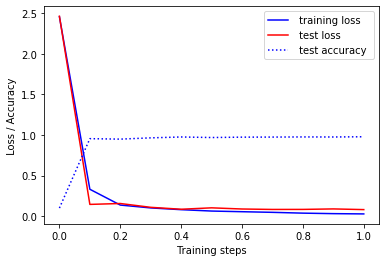

In [21]:
visualization(train_losses, test_losses ,test_accuracies)

### Assignment 3 Hyperparameters